In [35]:
import numpy as np
import os 
import re
import random
import pandas as pd
import subprocess
import shutil
import time
import sys
from tqdm import tqdm

from pymatgen.core import Element
from pymatgen.io.vasp import Poscar
from pymatgen.io.cif import CifWriter
from pymatgen.core import Composition
from pymatgen.analysis.structure_matcher import StructureMatcher

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.patches import Rectangle
from scipy.cluster.hierarchy import dendrogram, linkage

##---------PREPARE INPUTS VC-RELAX FROM CIF--------##

AtomSymb = np.asarray([str(e) for e in Element])[2:]
AtomMass = np.asarray([str(float(Element(e).atomic_mass)) for e in AtomSymb]) 

qe_input = {"calculation_type" : "vc-relax", 
"pseudo_dir" : "./pseudo",
"pseudo_tail" : "_ONCV_PBE_sr.upf",
"ecutwfc" : 80,
"occupations_scf" : "smearing",
"smearing_scf" : "marzari-vanderbilt",
"degauss_scf" : 0.02,
"el_conv_thr" : 1.0e-7,
"mixing_beta" : 0.7,
"ion_dynamics" : "bfgs",
"cell_dofree" : "ibrav",
"cell_dynamics" : "bfgs",
"press" : 500.0,
"kspacing_scf" : 0.25,
"kspacing_nscf" : 0.10,
"forc_conv_thr" : 1e-3,
"etot_conv_thr" : 1e-5,
"cell_factor" : 4.0 }


bohr_to_angstrom = 0.52917720859 # Bohr radius
grk_pi = 3.14159265358979323846  # pi
rad_to_deg = 180 / grk_pi        # from radians to degrees

#a, b, c are input qe parameters
def make_kmesh(a, b, c, spacing = 0.30):
    KP_x = int(2.*grk_pi / (a * spacing) + 0.5)
    if KP_x < 1:
        KP_x = 1
    KP_y = int(2.*grk_pi / (b * spacing) + 0.5)
    if KP_y < 1:
        KP_y = 1
    KP_z = int(2.*grk_pi / (c * spacing) + 0.5)
    if KP_z < 1:
        KP_z = 1
    return [KP_x, KP_y, KP_z]  ## number of kpoints in each direction

# Given ibrav value and angle in rad returns the lattice vectors of primitive and conventional cell
def get_bravais_vectors(ibrav, alphar, betar, gammar):
    if ibrav == 1:
        ## 1: simple_cubic
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        return conventional, primitive
    elif ibrav == 2:
        ## 2: face_centered_cubic
        conventional =  np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[-1/2,0,1/2],
                                 [0,1/2,1/2],
                                 [-1/2,1/2,0]])
    elif ibrav == 3:
        ## 3: body_centered_cubic
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1/2,1/2,1/2],
                                 [-1/2,1/2,1/2],
                                 [-1/2,-1/2,1/2]])
    elif ibrav == 4:
        ## 4: simple_hexagonal
        conventional = np.asarray([[1,0,0],
                                 [-1/2,np.sqrt(3)/2,0],
                                 [0,0,1]])
        primitive = np.asarray([[1,0,0],
                                 [-1/2,np.sqrt(3)/2,0],
                                 [0,0,1]])
    elif ibrav == 5:
        raise Warning("Trigonal axes not yet implemented.")
    elif ibrav == -5:
        raise Warning("Trigonal axes not yet implemented.")
    
    elif ibrav == 6:
    ## 6: simple_tetragonal
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
    elif ibrav == 7:
        ## 7: body_centered_tetragonal
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive =  np.asarray([[1/2,-1/2,1/2],
                                 [1/2,1/2,1/2],
                                 [-1/2,-1/2,1/2]])
    elif ibrav == 8:
        ## 8: orthorhombic_simple
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
    elif ibrav == 9:
        ## 9: orthorhombic_base_centered
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1/2,1/2,0],
                                 [-1/2,1/2,0],
                                 [0,0,1]])
    elif ibrav == -9:
        ## -9: orthorhombic_base_centered
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1/2,-1/2,0],
                                 [1/2,1/2,0],
                                 [0,0,1]])
    elif ibrav == 91:
     ## 91: orthorhombic_one_base_centered_a_type
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1,0,0],
                                 [0,1/2,-1/2],
                                 [0,1/2,1/2]])
    elif ibrav == 10:
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1/2,0,1/2],
                                 [1/2,1/2,0],
                                 [0,1/2,1/2]])
    elif ibrav == 11:
        ## 11: body_centered_orthorhombic
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1/2,1/2,1/2],
                                 [-1/2,1/2,1/2],
                                 [-1/2,-1/2,1/2]])
    elif ibrav == 12:
        ## 12: monoclinic, unique axis c
        conventional = np.asarray([[1,0,0],
                                 [np.cos(gammar),0,np.sin(gammar)],
                                 [0, 0, 1]])
        primitive = np.asarray([[1,0,0],
                                 [np.cos(gammar),0,np.sin(gammar)],
                                 [0, 0, 1]])
    elif ibrav == -12:
        ## -12: monoclinic, unique axis b
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [np.cos(betar),0,np.sin(betar)]])
        primitive = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [np.cos(betar),0,np.sin(betar)]])
    elif ibrav == 13:
        ## 13: monoclinic, unique axis c
        conventional = np.asarray([[1,0,0],
                                 [np.cos(gammar),0,np.sin(gammar)],
                                 [0, 0, 1]])
        primitive = np.asarray([[1/2,0,-1/2],
                                 [np.cos(gammar),np.sin(gammar),0],
                                 [1/2, 0, 1/2]])
    elif ibrav == -13:
        ## -13: monoclinic base-centered, unique axis b
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [np.cos(betar),0,np.sin(betar)]])
        primitive = np.asarray([[1/2,1/2,0],
                                 [-1/2,1/2,0],
                                 [np.cos(betar),0,np.sin(betar)]])
    elif ibrav == 14:
        ## 14: triclinic, I hope this is never ever called
        conventional = np.asarray([[1,0,0],
                                 [np.cos(gammar), np.sin(gammar),0],
                                 [np.cos(betar),
                                  (np.cos(alphar)-np.cos(betar)*np.cos(gammar))/np.sin(gammar),
                                  np.sqrt(1+2*np.cos(alphar)*np.cos(betar)*np.cos(gammar)-np.cos(alphar)**2-np.cos(betar)**2-np.cos(gammar)**2)/np.sin(gammar)]])
        primitive = np.asarray([[1,0,0],
                                 [np.cos(gammar), np.sin(gammar),0],
                                 [np.cos(betar),
                                  (np.cos(alphar)-np.cos(betar)*np.cos(gammar))/np.sin(gammar),
                                  np.sqrt(1+2*np.cos(alphar)*np.cos(betar)*np.cos(gammar)-np.cos(alphar)**2-np.cos(betar)**2-np.cos(gammar)**2)/np.sin(gammar)]])
    else:
        raise Warning("No valid ibrav found, which should never happen, ibrav is: " + str(ibrav))
    return conventional, primitive

def check_and_add_position_primitive(new_coord, new_atom, coord_list, type_list, direct_lattice, threshold=0.001):
    list_operations = []
    for i in range(-3, 3, 1): ## vector a1 up to 4 cells away in all directions
        for j in range(-3, 3, 1): ## vector a2 up to 4 cells away in all directions
            for k in range(-3, 3, 1): ## vector a3 up to 4 cells away in all directions
                list_operations.append(direct_lattice[:,0]*i + direct_lattice[:,1]*j + direct_lattice[:,2]*k)

    for operation in list_operations:
        for old_coord in coord_list:
                ## compare element by element whether old_coord and new_coord + operation are all the same or not
                ## if they are the same, do not add this atom
            if all(abs(a - b) <= threshold for a, b in zip(np.asarray(old_coord), new_coord+np.asarray(operation))):
                return coord_list, type_list
    ## if the code arrives here it means that this atomic position is not equivalent to the previous ones
    coord_list.append(new_coord)
    type_list.append(new_atom)
    return coord_list, type_list

## write necessary celldm parameters for each ibrav
def write_celldm(file, qe_input, qe_parameters):
    if int(qe_parameters["ibrav"]) != 0:
        file.write("   ibrav = " + str(int(qe_parameters["ibrav"])) + " \n")
        file.write("   nat = " + str(int(qe_parameters["nat"])) + " \n")
        file.write("   ntyp = " + str(int(qe_parameters["ntyp"])) + " \n")
        file.write("   celldm(1) = " + str(qe_parameters["a"]/bohr_to_angstrom) + " \n")
        if qe_parameters["ibrav"] in [4, 6, 7]:
            file.write("   celldm(3) = " + str(qe_parameters["c"]/qe_parameters["a"]) + " \n")
        elif qe_parameters["ibrav"] in [5, -5]:
            file.write("   celldm(4) = " + str(np.cos(qe_parameters["alphar"])) + " \n")
        elif qe_parameters["ibrav"] == 14:
            file.write("   celldm(2) = " + str(qe_parameters["b"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(3) = " + str(qe_parameters["c"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(4) = " + str(np.cos(qe_parameters["alphar"])) + " \n")
            file.write("   celldm(5) = " + str(np.cos(qe_parameters["betar"])) + " \n")
            file.write("   celldm(6) = " + str(np.cos(qe_parameters["gammar"])) + " \n")
        elif qe_parameters["ibrav"] == -12:
            file.write("   celldm(2) = " + str(qe_parameters["b"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(3) = " + str(qe_parameters["c"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(5) = " + str(np.cos(qe_parameters["betar"])) + " \n")
        elif qe_parameters["ibrav"] == 13:
            file.write("   celldm(2) = " + str(qe_parameters["b"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(3) = " + str(qe_parameters["c"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(4) = " + str(np.cos(qe_parameters["alphar"])) + " \n")
        elif qe_parameters["ibrav"] in [8, 9, 10, 11]:
            file.write("   celldm(2) = " + str(qe_parameters["b"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(3) = " + str(qe_parameters["c"]/qe_parameters["a"]) + " \n")
        elif qe_parameters["ibrav"] == 12:
            file.write("   celldm(2) = " + str(qe_parameters["b"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(3) = " + str(qe_parameters["c"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(4) = " + str(np.cos(qe_parameters["alphar"])) + " \n")
        elif qe_parameters["ibrav"] in [1, 2, 3]:
            pass

#Write base layer of the input file
def write_qe_input_lowlevel(file, qe_input, qe_parameters):
    ## Control   
    calculation_type = qe_input["calculation_type"]

    file.write("&CONTROL \n")
    file.write("   calculation = '" + calculation_type + "'\n")
    file.write("   restart_mode = 'from_scratch' \n")
    prefix = qe_parameters["chemical_formula"]
    file.write("   prefix = '" + prefix + "' \n")
    file.write("   tstress = .true. \n")
    file.write("   tprnfor = .true. \n")
    file.write("   pseudo_dir = '" + qe_input["pseudo_dir"] + "' \n")
    file.write("   outdir = './output' \n")
    file.write("   forc_conv_thr = " + str(qe_input["forc_conv_thr"]) + "\n")
    file.write("   etot_conv_thr = " + str(qe_input["etot_conv_thr"]) + "\n")
    file.write("&end \n")
    ## System
    file.write("&SYSTEM \n")
    write_celldm(file, qe_input, qe_parameters)
    file.write("   ecutwfc = " + str(qe_input["ecutwfc"]) + " \n")
    file.write("   occupations = '" + qe_input["occupations_scf"] + "' \n")
    file.write("   smearing = '" + qe_input["smearing_scf"] + "' \n")
    file.write("   degauss = " + str(qe_input["degauss_scf"]) + " \n")
    file.write("&end \n")
    ## Electrons
    file.write("&ELECTRONS \n")
    file.write("   conv_thr =  " + str(float(qe_input["el_conv_thr"])) + " \n")
    file.write("   mixing_beta = " + str(qe_input["mixing_beta"]) + " \n")
    file.write("&end \n")
    ## Ions
    file.write("&IONS \n")
    file.write("   ion_dynamics = '" + qe_input["ion_dynamics"] + "' \n")
    file.write("&end \n")
    ## Cell
    file.write("&CELL \n")
    file.write("   cell_dynamics = '" + qe_input["cell_dynamics"] + "' \n")
    file.write("   cell_dofree = '" + qe_input["cell_dofree"] + "' \n")
    #file.write("   cell_factor = " + str(float(qe_input["cell_factor"])) + " \n")
    file.write("   press = " + str(float(qe_input["press"])) + " \n")
    file.write("&end \n")
    file.write("\n")
    ## Atomic species
    file.write("ATOMIC_SPECIES \n")
    for i, specie in enumerate(qe_parameters["atomic_species"]):
        file.write("   " + specie + "   " + str(qe_parameters["atomic_masses"][i]) + "    " + specie + qe_input["pseudo_tail"] + " \n")
    file.write("\n")
    ## Atomic positions
    file.write("ATOMIC_POSITIONS crystal \n")
    for i, atom in enumerate(qe_parameters["atomic_coordinates"]):
        file.write("   " + qe_parameters["atomic_coordinates_types"][i] + "    " + 
                   str(qe_parameters["atomic_coordinates"][i][0]) + "    " + 
                   str(qe_parameters["atomic_coordinates"][i][1]) + "    " + 
                   str(qe_parameters["atomic_coordinates"][i][2]) + "    \n")
    ## K_POINTS
    file.write("K_POINTS automatic \n")
    if "kspacing_scf" in list(qe_input.keys()):
        kpoints = make_kmesh(qe_parameters["a"], qe_parameters["b"], qe_parameters["c"], spacing=qe_input["kspacing_scf"])
    else: 
        kpoints = make_kmesh(qe_parameters["a"], qe_parameters["b"], qe_parameters["c"], spacing=0.30)
    file.write(str(kpoints[0]) + "  " + str(kpoints[1]) + "  " + str(kpoints[2]) + "    0  0  0 " + " \n")

## Apply symmetry operation to a vector position to get a new vector position
def apply_symm_op(vec_pos, symm_op):
    x, y, z = vec_pos[0], vec_pos[1], vec_pos[2]
    new_vec_pos= [None, None, None]
    for i, coord in enumerate(symm_op):
        ## Replace symbolic coordinates with values
        op = symm_op[i].replace("x", "+"+str(x)).replace("y", "+"+str(y)).replace("z", "+"+str(z))
        ## Algebraic sign rules
        op = op.replace("--", "+").replace("-+", "-").replace("+-", "-").replace("++", "+")
        new_vec_pos[i] = float(eval(op))
        while new_vec_pos[i] < 0 :
            new_vec_pos[i] += 1.
        while new_vec_pos[i] >= 1. :
            new_vec_pos[i] -= 1.
    return new_vec_pos
    
## Function to identify Bravais lattice from lattice parameters
def find_lattice(a, b, c, alpha, beta, gamma):
    thr = 1.e-4
    bravais = ""
    if abs(alpha - 90.0) < thr and abs(gamma - 90.0) < thr:
        if abs(beta - 90.0) < thr:
            if abs(a - b) < thr and abs(a - c) < thr:
                bravais = "cubic"
            elif abs(a - b) < thr:
                bravais = "tetragonal"
            else:
                bravais = "orthorhombic"
        else:
            bravais = "monoclinic"
    elif abs(alpha - 90.0) < thr and abs(beta - 90.0) < thr and abs(gamma - 120.0) < thr:
        bravais = "hexagonal"
    elif abs(alpha - beta) < thr and abs(alpha - gamma) < thr and abs(a - b) < thr and abs(a - c) < thr:
        bravais = "rhombohedral"
    else:
        bravais = "triclinic"
    return bravais

## Function to find ibrav
def find_ibrav(spacegroup, bravais):
    ibrav = 0
    primitive = re.search("P", spacegroup) is not None
    bodycentered = re.search("I", spacegroup) is not None
    facecentered = re.search("F", spacegroup) is not None
    basecentered = re.search("C", spacegroup) is not None
    onefacebasecentered = re.search("A", spacegroup) is not None

    if bravais == "cubic":
        if primitive:
            ibrav = 1
        if facecentered:
            ibrav = 2
        if bodycentered:
            ibrav = 3
    elif bravais == "tetragonal":
        if primitive:
            ibrav = 6
        if bodycentered:
            ibrav = 7
    elif bravais == "orthorhombic":
        if primitive:
            ibrav = 8
        if basecentered:
            ibrav = 9
        if onefacebasecentered:
            ibrav = 91
        if facecentered:
            ibrav = 10
        if bodycentered:
            ibrav = 11
    elif bravais == "monoclinic":
        if primitive:
            ibrav = -12
        if basecentered:
            ibrav = 13
    elif bravais == "triclinic":
        ibrav = 14
    elif bravais == "hexagonal":
        ibrav = 4
    elif bravais == "rhombohedral":
        if primitive:
            ibrav = 4
        else:
            ibrav = 5
    else:
        ibrav = 0
    return ibrav

class PWSCf_input:
    def __init__(self, qe_input, cifname=None):
        self.name = None   ## name/identifier for structure
        self.cifname = cifname
        self.qe_input = qe_input
        ## Tolerance for recognizing identical atoms generated by symmetry
        self.threshold = 0.01
        self.totatom = 0
        self.num_symm_op = 0
        ## Store all symmetry operations
        self.symm_op_list = []
        ## Store atomic coordinates (pre sym-op)
        self.atomic_type_list = []
        self.atomic_coord_list = []
        self.qe_parameters = {}
        ## Store atomic coordinates and atom type (post sym-op)
        self.atomic_coord_list_extended = []
        self.atomic_type_list_extended = []
        ## Store list of atomic masses
        self.atomic_masses = []
        ## Internal consistency checks
        self.relax_read = False
        ## Relaxation checks
        self.off_diagonal_ok = None
        self.restart_diff_ok = None
        self.restart_forces_ok = None

    ## Reading keywords in cif file and add them to qe_parameters dictionary
    def read_cif(self):
        ## Token to count lines with symmetry operations
        count_symm_finished = False
        start_match = False
        ## Token to read lines with atomic positions
        start_readatoms = False
        with open(self.cifname) as cif_file:
            for line in cif_file.readlines():
                if "_symmetry_space_group_name_H-M" in line:
                    tmpspacegroup = line.split()[1]
                    self.qe_parameters["HMsg"] = tmpspacegroup
                elif "_cell_length_a" in line:
                    a = float(line.split()[1])
                    self.qe_parameters["a"] = a
                elif "_cell_length_b" in line:
                    b = float(line.split()[1])
                    self.qe_parameters["b"] = b
                elif "_cell_length_c" in line:
                    c = float(line.split()[1])
                    self.qe_parameters["c"] = c
                elif "_cell_angle_alpha" in line:
                    alpha = float(line.split()[1])
                    self.qe_parameters["alpha"] = alpha
                    self.qe_parameters["alphar"] = alpha / 180.0 * grk_pi
                    self.qe_parameters["cosab"] = np.cos(alpha / 180.0 * grk_pi)
                elif "_cell_angle_beta" in line:
                    beta = float(line.split()[1])
                    self.qe_parameters["beta"] = beta
                    self.qe_parameters["betar"] = beta / 180.0 * grk_pi
                    self.qe_parameters["cosbc"] = np.cos(beta / 180.0 * grk_pi)
                elif "_cell_angle_gamma" in line:
                    gamma = float(line.split()[1])
                    self.qe_parameters["gamma"] = gamma
                    self.qe_parameters["gammar"] = gamma / 180.0 * grk_pi
                    self.qe_parameters["cosac"] = np.cos(gamma / 180.0 * grk_pi)
                elif "_symmetry_Int_Tables_number" in line:
                    tmptablenumber = int(line.split()[1])
                    self.qe_parameters["NUMsg"] = tmptablenumber
                elif "_chemical_formula_structural" in line:
                    chemical_formula = line.split()[1]
                    self.qe_parameters["chemical_formula"] = chemical_formula
                elif "_chemical_formula_sum" in line:
                    chemical_formula_sum = line.replace("'","").split()[1:]
                    self.qe_parameters["formula_sum"] = chemical_formula_sum
                ## Count symmetry operations
                elif " _symmetry_equiv_pos_as_xyz" in line:
                    start_match = True
                elif start_match and not count_symm_finished:
                    self.num_symm_op += 1
                if ("loop_" in line) and start_match:
                    count_symm_finished = True
                    start_match = False
                    self.num_symm_op -= 1
                if start_match and self.num_symm_op > 0 :
                    self.symm_op_list.append(line.split("'")[1].replace("'","").replace(",","").split())
                ## Count symmetry operation ends
                ## Read atom type and coordinate begins
                if start_readatoms and line.strip():
                    self.atomic_coord_list.append(line.split()[3:6])
                    self.atomic_type_list.append(line.split()[0])
                if "_atom_site_occupancy" in line:
                    start_readatoms = True
                ## Read atom type and coordinate ends
        self.data_read = True
        self.generate_cell_data()
        self.generate_coords_sym()
        self.get_unique_atoms_list()
        self.name = self.qe_parameters["chemical_formula"] + "_" + str(self.qe_parameters["NUMsg"])

    ## Write the input file for Quantum Espresso
    def write_scf_input(self, qe_input_name="pw.scf.in"):
        if self.data_read:
            with open(qe_input_name, "w") as qe_input_file:
                write_qe_input_lowlevel(qe_input_file, self.qe_input, self.qe_parameters)
        else:
            print("Data was not read!")

    ## Get the name of atoms without repetition
    def get_unique_atoms_list(self):
        _, idx = np.unique(np.asarray(self.atomic_type_list_extended), return_index=True)
        self.qe_parameters["atomic_species"] = np.asarray(self.atomic_type_list_extended)[np.sort(idx)].tolist()
        for element in self.qe_parameters["atomic_species"]:
            self.atomic_masses.append(float(AtomMass[np.isin(AtomSymb, element)][0]))
        self.qe_parameters["atomic_masses"] = self.atomic_masses  

    def generate_coords_sym(self):
        if self.data_read:
            for a_i, atomic_coord in enumerate(self.atomic_coord_list):
                for symm_op in self.symm_op_list:
                    ## generate a new equivalent position using the allowed symmetry operations
                    eq_coord = apply_symm_op(atomic_coord, symm_op)
                    ## apply conversion from conventional to primitive basis
                    ## convert the coordinates from conventional to primitive using the transform matrices
                    ## defined from the qe convention. Note that the inverse of the transform matrix is used
                    ## because coordinates transform inversely w.r.t. lattice vectors
                    conventional, primitive = get_bravais_vectors(self.qe_parameters["ibrav"], self.qe_parameters["alphar"],
                                self.qe_parameters["betar"],self.qe_parameters["gammar"])
                    transform_matrix_prim_to_conv = conventional @ np.linalg.inv(primitive)
                    eq_coord_prim = (transform_matrix_prim_to_conv.T @ np.asarray(eq_coord).T).T
                    ## here the check for repetition is done already in the primitive cell
                    ## if the position was not present, it is added to self.atomic_coord_list_extended
                    check_and_add_position_primitive(eq_coord_prim, self.atomic_type_list[a_i], 
                    self.atomic_coord_list_extended, self.atomic_type_list_extended, 
                    primitive, threshold=self.threshold)
            ##

            self.qe_parameters["atomic_coordinates"] = self.atomic_coord_list_extended
            self.qe_parameters["atomic_coordinates_types"] = self.atomic_type_list_extended
            ## Number of atoms from composition
            self.nat = len(self.atomic_coord_list_extended)
            self.qe_parameters["nat"] = int(self.nat)

    ## Angles in radiants
    def generate_cell_data(self):
        ## Finding Bravais lattice and corresponding ibrav
        lattice = find_lattice(self.qe_parameters["a"], self.qe_parameters["b"], self.qe_parameters["c"], 
            self.qe_parameters["alpha"], self.qe_parameters["beta"], self.qe_parameters["gamma"])
        self.ibrav = find_ibrav(self.qe_parameters["HMsg"], lattice)
        ## Composition shenanigans
        self.composition = Composition(" ".join(self.qe_parameters["formula_sum"]))
        ## Number of type of atoms from composition
        self.ntyp = len(self.composition.formula.split(" "))

        self.qe_parameters["ibrav"] = self.ibrav
        self.qe_parameters["ntyp"] = self.ntyp



In [36]:
#Needs in input the name of the individuals file and saves it in a pandas df
def read_individuals(individuals):
    column_names = {0 : "Generation", 1 : "ID", 2 : "GenMode", 
    4 : 'A', 5 : 'B', 7 : "enthalpy", 10 : "fitness", 15 : "spacegroup"}

    individuals = pd.read_csv(individuals, sep="\s+", header=None, skiprows=2,usecols=column_names)
    individuals.rename(columns=column_names, inplace=True)
    individuals.sort_values("fitness", inplace=True)
    return individuals

#Needs in input the name of the file with all the poscars, the id of the structure to be extracted and the name of the output poscar
def find_poscar(all_poscars, id):
    end=-1
    with open(all_poscars,'r') as file:
        testo_input = file.readlines()              
    for i, line in enumerate(testo_input):
        if line.startswith('EA'+str(id)):   
            init = i
            simm=int(line[line.find(':')+1:])
        if line.startswith('EA'+str(id+1)):
            end = i-1
            break
    if end == -1:                            
        end = len(testo_input)-1
        
    poscar_str=''
    for i in range(end-init+1):
        poscar_str+=testo_input[init+i]
    return poscar_str

#Needs df of Individuals, fitness treshold, file gatheredPoscars and return best non duplicated structures (with symm>75)
def best_structures(individuals_df, fitness_upto, all_poscars):
    fitness_gs = individuals_df['fitness'].iloc[0]
    uniques = []
    SGs=[]
    structure_gs = Poscar.from_str(find_poscar(all_poscars, individuals_df['ID'].iloc[0]))
    
    if individuals_df['spacegroup'].iloc[0] > 75:# and individuals_df['spacegroup'].iloc[0] != 187:
        uniques.append(structure_gs)
        SGs.append(individuals_df['spacegroup'].iloc[0])

    for i, line_individuals_df in individuals_df.iterrows():
        if line_individuals_df['fitness'] - fitness_gs >= fitness_upto:
            break
        if line_individuals_df['spacegroup'] < 75:# or line_individuals_df['spacegroup'] == 187:
            continue
        new_structure = Poscar.from_str(find_poscar(all_poscars, line_individuals_df['ID']))

        check_dupilcate = False
        
        if StructureMatcher(ltol = 1.0, stol = 1.0, angle_tol = 10, scale=True).fit(structure_gs.structure, new_structure.structure):
            check_dupilcate = True 
        
        for structure in uniques:
            if StructureMatcher(ltol = 1.0, stol = 1.0, angle_tol = 10, scale=True).fit(structure.structure, new_structure.structure):
                check_dupilcate = True
        if not check_dupilcate:
            uniques.append(new_structure)
            SGs.append(line_individuals_df['spacegroup'])
    return uniques, SGs

#Needs in input the name of the poscar and the name of the cif in output     
def poscar_to_cif(poscar, cif, symprec, angprec):
    poscar = Poscar.from_str(poscar, read_velocities=True)
    try:
        cif_structure = CifWriter(poscar.structure, symprec=symprec, angle_tolerance=angprec)
    except:
        print("Pymatgen returned an error. Your symprec might be too large")
    cif_structure.write_file(cif)
    return

#Copy Individuals and gatheredPoscars files 
def copy_files(A, B):
    dir_all_Individuals='./all_Individuals/'
    dir_all_poscars='./all_poscars/'
    shutil.copyfile(f'./AB/OUTPUTFILES/{A+B}/{A+B}_gatheredPOSCARS', dir_all_poscars+f'{A+B}_gatheredPOSCARS')
    shutil.copyfile(f'./AB/OUTPUTFILES/{A+B}/{A+B}_Individuals', dir_all_Individuals+f'{A+B}_Individuals')
    return

#Take the poscar in str format and write the qe input
def poscar_to_input(poscar, id, qe_input=qe_input):
    dir_all_cif='./all_cif/'
    dir_all_qeinput='./all_qeinput/'
    poscar_to_cif(poscar, dir_all_cif + f'{id}.cif', 0.4, 5)
    qe = PWSCf_input(qe_input, cifname=dir_all_cif + f'{id}.cif')
    qe.read_cif()
    qe.write_scf_input(qe_input_name=dir_all_qeinput+f'{id}.in')
    return

#Modify only the names of elements in atomic positions
def modify_qe_atomic_positions(input, new_input, A, B):
    old_el=[]
    new_el=[A,B]
    check = False
    with open(input, 'r') as file:
        testo_input=file.readlines()
    
    for i, line in enumerate(testo_input):
        if line.startswith('ATOMIC_SPECIES'):
            old_el.append(testo_input[i+1].split()[0])
            old_el.append(testo_input[i+2].split()[0])
        if line.startswith('K_POINTS'):
            check = False
        if check:
            atom=line.split()[0]
            testo_input[i]=line.replace(atom,new_el[old_el.index(atom)])
        if line.startswith('ATOMIC_POSITIONS'):
            check = True
     
    with open(new_input, 'w') as file:
        file.writelines(testo_input)
    return

#Needs in input the name of the qe input, the species and their mass
def modify_qe_input_element(template, qe_input, A, B, mA, mB):
    with open(template, 'r') as file:
            testo_input=file.readlines()
    for i, line in enumerate(testo_input):
        if line.startswith('  prefix'):
            testo_input[i]=f'  prefix = \'{A}{B}\'\n'            
        if line.startswith('ATOMIC_SPECIES'):
            testo_input[i+1]=f'{A} {mA} {A}_ONCV_PBE_sr.upf\n'
            testo_input[i+2]=f'{B} {mB} {B}_ONCV_PBE_sr.upf\n'    
            break
    with open(qe_input, 'w') as file:
            file.writelines(testo_input)
    return


#Setup the QE input using a template, celldm array, species A and B and their masses
def setup_QEinput(input, new_input, A, B, mA, mB):
    modify_qe_atomic_positions(input, new_input, A, B)
    modify_qe_input_element(new_input, new_input, A, B, mA, mB) 

    return



###--------MANAGE QUANTUM ESPRESSO I/O--------###

#### RUN

#Run pw.x in parallel using file input and output
def run_pw(fileinput, fileoutput, nproc):
    return
    commmand=f'mpirun -np {nproc} -x OMP_NUM_THREADS=1 pw.x < ' + fileinput + '>' + fileoutput
    set_elconvthr(fileinput, 1e-4)
    os.system(commmand)
    celldm_vec=find_celldm(fileoutput)
    set_celldm(fileinput, celldm_vec)
    set_elconvthr(fileinput, 1e-6)
    os.system(commmand)
    celldm_vec=find_celldm(fileoutput)
    set_elconvthr(fileinput, 1e-8)
    set_celldm(fileinput, celldm_vec)
    os.system(commmand)
    return

#Check if the run is converged
def check_convergence(file_output, n_fails, A, B):
    return True
    dir_all_qeoutput='./all_qeoutput/'

    with open(dir_all_qeoutput + file_output, 'r') as file:
        flag = False
        for line in file:
            if line.startswith('     Final scf calculation at the relaxed structure.'):
                flag = True
            if flag and line.startswith('     convergence has been achieved'):
                return True
            
        create_directory('./NotConverged')
        shutil.copyfile(dir_all_qeoutput + file_output, f'./NotConverged/{n_fails+1}_{A + B + file_output}')

    return False

#Set the celldm in the input file
def set_celldm(fileinput, celldm_vec):

    with open(fileinput, 'r') as file:
        testo_input=file.readlines()
    for i, line in enumerate(testo_input):
        if line.startswith('   celldm(1)'):
            testo_input[i]=f'   celldm(1) = {celldm_vec[0]}\n'
        if line.startswith('   celldm(2)'):
            testo_input[i]=f'   celldm(2) = {celldm_vec[1]}\n'
        if line.startswith('   celldm(3)'):
            testo_input[i]=f'   celldm(3) = {celldm_vec[2]}\n'
        if line.startswith('   celldm(4)'):
            testo_input[i]=f'   celldm(4) = {celldm_vec[3]}\n'
        if line.startswith('   celldm(5)'):
            testo_input[i]=f'   celldm(5) = {celldm_vec[4]}\n'
        if line.startswith('   celldm(6)'):
            testo_input[i]=f'   celldm(6) = {celldm_vec[5]}\n'
    with open(fileinput, 'w') as file:
        file.writelines(testo_input)
    return

#set the elconvthr in the input file
def set_elconvthr(fileinput, elconvthr):

    with open(fileinput, 'r') as file:
        testo_input=file.readlines()
    for i, line in enumerate(testo_input):
        if line.startswith('   conv_thr'):
            testo_input[i]=f'   conv_thr =  {elconvthr}\n'
    with open(fileinput, 'w') as file:
        
        file.writelines(testo_input)
    return

#Change the celldm1 in the input file in order to make more easy the vc relax
def change_celldm1(file_input, A_old, B_old, A_new, B_new, comp): 
    A_old_r= float(Element(A_old).atomic_radius)
    B_old_r= float(Element(B_old).atomic_radius)
    A_new_r= float(Element(A_new).atomic_radius)
    B_new_r= float(Element(B_new).atomic_radius)    

    with open(file_input, 'r') as file:
        testo_input=file.readlines()
    for i, line in enumerate(testo_input):
        if line.startswith('   celldm(1)'):
            celldm_old=float(re.search(r'-?\d+.\d+',line).group())
            celldm_new = celldm_old * (A_new_r * comp + B_new_r ) / ( A_old_r * comp +B_old_r )
            testo_input[i]='   celldm(1) = ' + str(celldm_new) + ' \n'
            break
    with open(file_input, 'w') as file:
        file.writelines(testo_input)
    return   


#Needs output file of QE and return array of celldm
def find_celldm(file_output):
    celldm=np.full(6,0.0)
    
    with open(file_output, 'r') as file:
        for line in file:                                               #find i valori di partenza dei celldm
            if line.startswith('     celldm(1)'):
                dm = (re.search(r'celldm\(1\)=\s*-?\d+.\d+',line)).group()
                celldm[0] = float(dm[dm.find('=') + 1 : ])

                dm = (re.search(r'celldm\(2\)=\s*-?\d+.\d+',line)).group()
                celldm[1] = float(dm[dm.find('=') + 1 : ])
                
                dm = (re.search(r'celldm\(3\)=\s*-?\d+.\d+',line)).group()
                celldm[2] = float(dm[dm.find('=') + 1 : ])

            if line.startswith('    celldm(4)'):
                dm = (re.search(r'celldm\(4\)=\s*-?\d+.\d+',line)).group()
                celldm[3] = float(dm[dm.find('=') + 1 : ])

                dm = (re.search(r'celldm\(5\)=\s*-?\d+.\d+',line)).group()
                celldm[4] = float(dm[dm.find('=') + 1 : ])

                dm = (re.search(r'celldm\(6\)=\s*-?\d+.\d+',line)).group()
                celldm[5] = float(dm[dm.find('=') + 1 : ])                    
                
                break
    with open(file_output, 'r') as file:
        for i in file:   
            if i.startswith(' celldm'):
                dm = (re.search(r'celldm\(\d\) =\s*-?\d+.\d+',i)).group()
                celldm[int(dm[7])-1] = float(dm[dm.find('=') + 1 : ])                
    return celldm



#Find enthalpy from output file of QE
def find_enthalpy(file_output):
    
    with open(file_output, 'r') as file:
        for line in file:
            if line.startswith('     Final enthalpy'):
                enthalpy = re.search(r'-?\d+.\d+',line[line.find('=')+1:])

    return float(enthalpy.group())*13.6

#Find natm from output file of QE
def find_natm(file_output):

    with open(file_output, 'r') as file:
        for line in file:
            if line.startswith('     number of atoms/cell'):
                natm = re.search(r'\d+',line[line.find('='):])
                break
          
    return float(natm.group())



#Find element type in the qe input file (for change in celldm1)
def find_element_type(file_input):
    with open(file_input) as file:
        testo_input = file.readlines()

    for i, line in enumerate(testo_input):
        if line.startswith('ATOMIC_SPECIES'):
            A = testo_input[i+1].split()[0]
            B = testo_input[i+2].split()[0]
            break
    return A, B

#Find Enthalpy from previous relaxed

def find_enthalpy_relaxed(df, gen_couple, rel_couple, sg):
    try:
        enthalpy = df.loc[rel_couple, f'{gen_couple}_{sg}']
    except Exception as e:
        print(f"Si è verificato un errore: {e}")
        return None
    return enthalpy

####----------------------------MANAGE FILE FUNCTIONS---------------------------------####

#Remove the file
def remove_file(file):
    if os.path.exists(file):
        os.remove(file)
    return

#Remove the directory
def remove_directory(directory):
    if os.path.exists(directory):
        subprocess.run(['rm', '-r', directory])        
    return

#Create the directory
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    return



###-----------------MANAGE TEMPLATES-----------------###

# Compute the Levenshtein distance between two arrays
def levensthein_distance(a1,a2):
    dist=0
    for i in range(len(a1)):
        if a1[i] != a2[i]:
            dist+=1-float(i)/len(a1)
    return dist

class TemplateSet:
    def __init__(self, file = None, comp = 1 ):
        self.dir_all_Individuals = './all_Individuals/'
        self.dir_all_poscars = './all_poscars/'
        self.dir_all_qeoutput = './all_qeoutput/'
        self.dir_all_qeinput = './all_qeinput/'
        self.dir_all_cif = './all_cif/'
        create_directory(self.dir_all_cif)
        create_directory(self.dir_all_Individuals)
        create_directory(self.dir_all_poscars)
        create_directory(self.dir_all_qeoutput)
        create_directory(self.dir_all_qeinput)

        self.gen_couples = [['B','Be'],['Be','O'],['B','Li'], ['B','N'], ['Mg','O'], ['C','Li'], ['C','N'], ['Li','Mg'], ['B','C'], ['N','O'], ['Li','N'], ['Mg','Na'], ['Li','Na'],['Mg','N'],['Li','O']]
        self.info_couples = [(['Mg', 'Na'], 123, ['1a', '1d']), (['Li', 'Na'], 187, ['1a', '1d']), (['Li', 'Na'], 194, ['2a', '2c']), (['Li', 'Na'], 123, ['1a', '1d']), (['B', 'N'], 216, ['4b', '4c']), (['B', 'N'], 186, ['2b', '2b']), (['B', 'Be'], 164, ['2d', '2d']), (['B', 'Li'], 166, ['6c', '6c']), (['B', 'C'], 139, ['4d', '4e']), (['Mg', 'N'], 187, ['1c', '1f', '2g']), (['Mg', 'O'], 225, ['4a', '4b']), (['Li', 'Mg'], 123, ['1a', '1d']), (['N', 'O'], 160, ['3a', '3a']), (['Li', 'N'], 139, ['4e', '4e']), (['C', 'N'], 166, ['6c', '6c']), (['C', 'N'], 164, ['2c', '2d']), (['Be', 'O'], 186, ['2b', '2b']), (['Be', 'O'], 216, ['4a', '4d']), (['Li', 'O'], 187, ['1c', '1f', '2g']), (['C', 'Li'], 164, ['2d', '2d']), (['C', 'Li'], 160, ['3a', '3a', '3a', '3a'])]


        self.df = pd.read_csv('./AB/A1B_relaxation/RELAX_DATA', sep=",", index_col=0)

        self.comp = comp
        self.num_template = 0
        self.n_fails = 0
        
        self.couples = [] #Couples chosen for the templates
        self.banned_couples = [] #Couples with no available templates (Already  chosen or non existent)
        self.poscars = []
        
        self.from_scratch = True
        self.flag_conv = True

        self.trial_SG = None
        self.trial_poscar = None
        self.trial_couple = None
        self.trial_wyckoff = None
        
        if file is not None:
            self.from_scratch = False
            
            flag_couples=False
            flag_ent=False
            flag_idx=False
            flag_poscars=False
            flag_ea=False
            
            with open(file, 'r') as input:
                lines=input.readlines()
            
            for line in lines:
                if line.startswith('NUMBER OF TEMPLATES'):
                    self.num_template = int(re.search(r'\d+',line).group())
                    self.data = np.zeros((2, self.num_template, self.num_template))
                if line.startswith('COMPOSITION'):
                    self.comp= float(re.search(r'\d+(.\d+)?', line).group())
                if flag_poscars:
                    if line.startswith('EA'):
                        if flag_ea:
                            self.poscars.append(poscar_str)
                        flag_ea = True
                        poscar_str=''
                    poscar_str+=line
                if line.startswith('POSCARS'):
                    flag_poscars = True
                    flag_idx = False
                if flag_idx:
                    self.data[1,int(line[:line.find(':')])]=(np.array(line[line.find('[')+1:line.find(']')].split())).astype(float)
                if line.startswith('RANKING VECTORS IDX'):
                    flag_idx = True
                    flag_ent = False
                if flag_ent:
                    self.data[0,int(line[:line.find(':')])]=(np.array(line[line.find('[')+1:line.find(']')].split())).astype(float)
                if line.startswith('RANKING VECTORS ENTHALPIES'):
                    flag_ent = True
                    flag_couples = False                    
                if flag_couples:
                    new_tuple = (line[line.find('[')+1:line.find(']')].split(), int(line[line.find(',')+1:]) )
                    self.couples.append(new_tuple)
                if line.startswith('COUPLES'):
                    flag_couples = True      
            self.poscars.append(poscar_str)
            
            for i, poscar in enumerate(self.poscars):
                poscar_to_input(poscar, i, qe_input=qe_input)
        return

    def is_not_in_couple(self, SG):
        for i in self.couples:
            if i[1] == SG:
                return False
        return True
    
    def try_new_couple(self, test_elements):
        self.trial_couple = None
        self.trial_poscar = None
        self.trial_SG = None
        self.trial_wycoff = None
        count_flag = 0
        while count_flag<=50:
            count_flag+=1
            extraction_list = [x for x in self.gen_couples if x not in self.banned_couples]
            causal_el = random.sample(extraction_list,1)
            causal_el = [x for y in causal_el for x in y]
            causal_el.sort() ##to be commented for other compositions
            
            A=causal_el[0]
            B=causal_el[1]
            
            print(f'Trying generating new template with: {A+B} (Try #{count_flag})\n')
            copy_files(A, B)

            df_individuals = read_individuals(self.dir_all_Individuals+f'{A+B}_Individuals')
            P, SG = best_structures(df_individuals, 0.1, self.dir_all_poscars+f'{A+B}_gatheredPOSCARS')
                
            if len(SG) > 0:
                print(f'There are {len(SG)} possible templates: {SG}\n')
                self.trial_couple = causal_el
                for k in range(len(SG)):
                    idx_couples = [i for i,x in enumerate(self.couples) if x[1] == SG[k]]
                    if self.is_not_in_couple(SG[k]):
                        self.trial_poscar = P[k]
                        self.trial_SG = int(SG[k])
                        self.trial_wyckoff = [self.info_couples[i][2] for i in range(len(self.info_couples)) if self.info_couples[i][0] == self.trial_couple and self.info_couples[i][1] == SG[k]][0]
                        break
                if self.trial_SG is None:
                    print(f'All possible templates simmetries are already chosen: {SG}\n')
                    for k in range(len(SG)):
                        idx = []
                        idx_couples = [i for i,x in enumerate(self.couples) if x[1] == SG[k]]
                        for m in idx_couples:
                            idx.extend([i for i,x in enumerate(self.info_couples) if x[0] == self.couples[m][0] and x[1] == SG[k]])
                        wyckoff = [self.info_couples[i][2] for i in range(len(self.info_couples)) if self.info_couples[i][0] == self.trial_couple and self.info_couples[i][1] == SG[k]][0]

                        for l in idx:
                            template_already_chosen = False
                            if self.info_couples[l][2] == wyckoff:
                                print(f'The couple has been already chosen with {self.info_couples[l]}\n')
                                template_already_chosen = True
                                break
                        
                        if not template_already_chosen:
                            self.trial_poscar = P[k]
                            self.trial_SG = int(SG[k])
                            self.trial_wyckoff = wyckoff
                            break
                    if template_already_chosen:
                        self.banned_couples.append(self.trial_couple)
                        print(f'All the structure near ground state have been already chosen: the couple {self.trial_couple[0]+self.trial_couple[1]} won\'t be sorted again\n')
                        continue
                break   
            else:
                print(f'No structures with high simmetry near ground state: choosign new couple\n')
                self.banned_couples.append(causal_el)
                continue
        poscar_to_input(str(self.trial_poscar), self.num_template)
        print(f'The couple {A+B} tries to make a structure with spacegroup {self.trial_SG} as the {self.num_template+1}-th template\n')
        
        return len(SG)
    
    def make_ranking_vec(self):
        self.flag_conv = True
        new_ranking = np.zeros((2, self.num_template))  
        A = self.trial_couple[0]
        B = self.trial_couple[1]

        for i in range(self.num_template):
        
            #print(f'Running {i}-th relaxation for ranking vector for couple {A+B}\n')
            overwrite_A, overwrite_B = find_element_type(self.dir_all_qeinput+f'{i}.in')
            change_celldm1(self.dir_all_qeinput+f'{i}.in', overwrite_A, overwrite_B, A , B, self.comp )
        
            setup_QEinput(self.dir_all_qeinput+f'{i}.in',self.dir_all_qeinput+f'{i}.in', str(Element(A)), str(Element(B)), float(Element(A).atomic_mass), float(Element(B).atomic_mass))
            run_pw(self.dir_all_qeinput+f'{i}.in', self.dir_all_qeoutput+f'{i}.out', 4) 
        
            self.flag_conv =  check_convergence(f'{i}.out', self.n_fails, A , B)
            if not self.flag_conv:
                #print(f'WARNING: {i}-th relaxation did not converge, skipped the couple {A+B}\n')
                self.n_fail+=1
                if self.trial_couple not in self.banned_couples:
                    self.banned_couples.append(self.trial_couple)
                new_ranking[:]=-1
                break

            if self.flag_conv:
                new_ranking[0,i]= find_enthalpy_relaxed(self.df,f'{self.couples[i][0][0]+self.couples[i][0][1]}', f'{self.trial_couple[0]+self.trial_couple[1]}', self.couples[i][1]) #find_enthalpy(self.dir_all_qeoutput+f'{i}.out')/find_natm(self.dir_all_qeoutput+f'{i}.out')                                           
                new_ranking[1,i] = int(i)    
                new_ranking = new_ranking[:, new_ranking[0].argsort()]   
        
        return new_ranking
    
    def own_relax(self, ranking_vec = np.array([[],[]]) ):
        A = self.trial_couple[0]
        B = self.trial_couple[1]

        #print('Running relaxation on own template...\n')
        setup_QEinput(self.dir_all_qeinput+f'{self.num_template}.in',self.dir_all_qeinput+f'{self.num_template}.in', str(Element(A)), str(Element(B)), float(Element(A).atomic_mass), float(Element(B).atomic_mass))
        run_pw(self.dir_all_qeinput+f'{self.num_template}.in', self.dir_all_qeoutput+f'{self.num_template}.out', 4)
        new_fitness= find_enthalpy_relaxed(self.df,f'{self.trial_couple[0]+self.trial_couple[1]}', f'{self.trial_couple[0]+self.trial_couple[1]}', self.trial_SG) #find_enthalpy(self.dir_all_qeoutput+f'{self.num_template}.out')/find_natm(self.dir_all_qeoutput+f'{self.num_template}.out')
        new_ranking = np.append(ranking_vec, [[new_fitness], [self.num_template]], axis=1)

        if self.num_template == 0:
            self.data = np.zeros((2,1,1))
            self.data[0] = new_ranking[0]
            self.data[1] = new_ranking[1]

        return new_ranking

    def relax_on_new_template(self):
        self.flag_conv = True
        couples = self.couples
        num_template = self.num_template

        new_column = np.zeros(num_template)
        for i, couple in enumerate(couples):
            #print(f'Running relaxation on new template for the {i}-th couple...\n')
            overwrite_A, overwrite_B = find_element_type(self.dir_all_qeinput+f'{num_template}.in')
            change_celldm1(self.dir_all_qeinput+f'{num_template}.in', overwrite_A, overwrite_B, str(Element(couple[0][0])) , str(Element(couple[0][1])), self.comp)
            setup_QEinput(self.dir_all_qeinput+f'{num_template}.in',self.dir_all_qeinput+f'{num_template}.in', str(Element(couple[0][0])), str(Element(couple[0][1])), float(Element(couple[0][0]).atomic_mass), float(Element(couple[0][1]).atomic_mass))
            run_pw(self.dir_all_qeinput+f'{num_template}.in', self.dir_all_qeoutput+f'{num_template}.out', 4)
            self.flag_conv =  check_convergence(f'{num_template}.out', self.n_fails, self.trial_couple[0] , self.trial_couple[1])

            if not self.flag_conv:
                #print(f'WARNING: {i}-th relaxation did not converge, skipped the couple {self.trial_couple[0]+self.trial_couple[1]}\n')
                new_column[:] = -1
                self.n_fails+=1
                if self.trial_couple not in self.banned_couples:
                    self.banned_couples.append(self.trial_couple)
                break
            if self.flag_conv:
                new_column[i] = find_enthalpy_relaxed(self.df,f'{self.trial_couple[0]+self.trial_couple[1]}', f'{couple[0][0]+couple[0][1]}', self.trial_SG) #find_enthalpy(self.dir_all_qeoutput+f'{num_template}.out')/find_natm(self.dir_all_qeoutput+f'{num_template}.out')
        if self.flag_conv:
            self.add_column(new_column)
        return new_column

    def add_column(self, column_values):
        # Add new column to the end of each matrix
        idx_column = np.full((self.data.shape[1]),self.num_template)
        self.data = np.pad(self.data, ((0, 0), (0, 0), (0, 1)), constant_values=0)
        self.data[0,:,-1] = column_values
        self.data[1,:,-1] = idx_column
        return

    def add_row(self, row_values, idx_row):
        # Add new row to the end of each matrix
        self.data = np.pad(self.data, ((0, 0), (0, 1), (0, 0)), constant_values=0)
        self.data[0,-1,:] = row_values
        self.data[1,-1,:] = idx_row
        return
    
    def order(self):
        # Order the matrix by rows of first matrix
        sorted_indices = np.argsort(self.data[0], axis=1)
        for i in range(self.data.shape[1]):
            self.data[0,i] = self.data[0,i, sorted_indices[i]]
            self.data[1,i] = self.data[1,i, sorted_indices[i]]
        return
    
    def distance(self, array):
        # Compute the Levenshtein distance between the rows of the first matrix and the array
        lev = np.zeros(self.data.shape[1])
        for i in range(self.data.shape[1]):
            lev[i] = levensthein_distance(self.data[1,i], array)
        return lev

    def update(self, n_possible_templates):
        new_tuple = (self.trial_couple, self.trial_SG, self.trial_wyckoff)
        self.couples.append(new_tuple)
        self.poscars.append(self.trial_poscar)
        self.num_template += 1
        self.order()
        print(f'The new template has been added to the set succesfully: {self.trial_couple[0]+self.trial_couple[1]} {self.trial_SG} \n')
        count = 0
        for i in self.couples:
            if i[0] == self.trial_couple:
                count+=1
        if count == n_possible_templates:
            print(f'All the structure near ground state have been already chosen: the couple {self.trial_couple[0]+self.trial_couple[1]} won\'t be sorted again\n')
            self.banned_couples.append(self.trial_couple)
        return 
    
    def print_file(self, file = None):
        if file is not None:
            relax_file = file
        else:
            relax_file = f'TemplateSet_{self.comp}'
        with open(relax_file, 'w') as file:
            file.write(f'NUMBER OF TEMPLATES {self.num_template}\n')
            file.write(f'COMPOSITION A {self.comp} B\n')
            file.write('COUPLES , SPACEGROUPS \n')
            for i, couple in enumerate(self.couples):
                file.write(f'[{couple[0][0]} {couple[0][1]}] , {couple[1]} \n')    
            file.write('RANKING VECTORS ENTHALPIES\n')
            for i, vec in enumerate(self.data[0]):
                arr = str(vec).replace('\n','')
                file.write(f'{i}:{arr} \n')
            file.write('RANKING VECTORS IDX\n')
            for i, vec in enumerate(self.data[1]):
                arr = str(vec).replace('\n','')
                file.write(f'{i}:{arr} \n')  
            file.write('POSCARS\n')
            for i in self.poscars:
                file.write(str(i))
        return
class PairSet:
    def __init__(self, template_set, test_elements, relaxed_pairs = None, comp=1 ) -> None:
        
        #DA METTERE INDIPENDENZA DA TEMPLATE SET
        self.test_elements=test_elements
        self.from_scratch = True   
        self.num_pairs = 0
        self.n_fails = 0
        self.num_template = template_set.num_template
        self.comp = template_set.comp

        self.couples = []


        self.banned_couples = []
        self.poscars = template_set.poscars
        self.sg = []
        self.gen_couples = []
        for i in template_set.couples:
            self.sg.append(i[1])
            self.gen_couples.append(i[0])

        self.data = np.zeros((3, self.num_template, self.num_pairs))

        self.dir_all_cif = './all_cif/'
        self.dir_all_qeoutput = './all_qeoutput/'
        self.dir_all_qeinput = './all_qeinput/'
        create_directory(self.dir_all_cif)
        create_directory(self.dir_all_qeoutput)
        create_directory(self.dir_all_qeinput)

        self.df = pd.read_csv('./AB/A1B_relaxation/RELAX_DATA', sep=",", index_col=0)
        self.one_el = pd.read_csv('./AB/A1B_relaxation/OneElementEnt.txt', sep=',', header=None)
        self.gs_df = pd.read_csv('./AB/A1B_relaxation/GroundStates.txt', sep=",")
        self.couples_info = [(['Mg', 'Na'], 123, ['1a', '1d']), (['Li', 'Na'], 187, ['1a', '1d']), (['Li', 'Na'], 194, ['2a', '2c']), (['Li', 'Na'], 123, ['1a', '1d']), (['B', 'N'], 216, ['4b', '4c']), (['B', 'N'], 186, ['2b', '2b']), (['B', 'Be'], 164, ['2d', '2d']), (['B', 'Li'], 166, ['6c', '6c']), (['B', 'C'], 139, ['4d', '4e']), (['Mg', 'N'], 187, ['1c', '1f', '2g']), (['Mg', 'O'], 225, ['4a', '4b']), (['Li', 'Mg'], 123, ['1a', '1d']), (['N', 'O'], 160, ['3a', '3a']), (['Li', 'N'], 139, ['4e', '4e']), (['C', 'N'], 166, ['6c', '6c']), (['C', 'N'], 164, ['2c', '2d']), (['Be', 'O'], 186, ['2b', '2b']), (['Be', 'O'], 216, ['4a', '4d']), (['Li', 'O'], 187, ['1c', '1f', '2g']), (['C', 'Li'], 164, ['2d', '2d']), (['C', 'Li'], 160, ['3a', '3a', '3a', '3a'])]

        
        if relaxed_pairs is not None:
            self.from_scratch = False

            flag_couples=False
            flag_ent=False
            flag_idx_2=False
            flag_idx=False

            with open(relaxed_pairs, 'r') as input_file:
                lines=input_file.readlines()
            
            for line in lines:
                if line.startswith('NUMBER OF PAIRS'):
                    self.num_pairs= int(re.search(r'\d+', line).group())
                if line.startswith('COMPOSITION A'):
                    self.comp= int(re.search(r'\d+', line).group())
                if line.startswith('NUMBER OF TEMPLATES'):
                    self.num_template= int(re.search(r'\d+', line).group())
                    self.data = np.zeros((3, self.num_template, self.num_pairs))
                if flag_idx_2:
                    self.data[2,int(line[:line.find(':')])]=(np.array(line[line.find('[')+1:line.find(']')].split())).astype(float)  
                if line.startswith('R(P) IDX'):
                    flag_idx_2 = True
                    flag_idx = False
                if flag_idx:
                    self.data[1,int(line[:line.find(':')])]=(np.array(line[line.find('[')+1:line.find(']')].split())).astype(float)  
                if line.startswith('R(T) IDX'):
                    flag_idx = True
                    flag_ent = False
                if flag_ent:
                    self.data[0,int(line[:line.find(':')])]=(np.array(line[line.find('[')+1:line.find(']')].split())).astype(float)
                if line.startswith('RANKING VECTORS ENTHALPIES'):
                    flag_ent = True
                    flag_couples = False                    
                if flag_couples:
                    self.couples.append(line[line.find('[')+1:line.find(']')].split())
                if line.startswith('RELAXED COUPLES'):
                    flag_couples = True      
        pass

    def add_pair(self):
        tries=0
        while True:
            if tries>=5:
                print('WARNING: too many tries, no new pair added\n')
                return
            tries+=1
            while True:
                causal_el = random.sample(self.test_elements, 2)
                causal_el.sort() ##to be commented for other compositions
                if causal_el in self.banned_couples:
                    continue
                elif causal_el not in self.couples:
                    A=causal_el[0]
                    B=causal_el[1]
                    break
            print(f'Trying add to pair-set the couple {A+B} (Try#{tries})\n')

            new_ranking = np.zeros(self.num_template)
            for i in range(self.num_template):
                #print(f'Running relaxation on {i}-th template with couple {A+B}\n')
                overwrite_A, overwrite_B = find_element_type(self.dir_all_qeinput+f'{i}.in')
                change_celldm1(self.dir_all_qeinput+f'{i}.in', overwrite_A, overwrite_B, A , B, self.comp)
                setup_QEinput(self.dir_all_qeinput+f'{i}.in',self.dir_all_qeinput+f'{i}.in', str(Element(A)), str(Element(B)), float(Element(A).atomic_mass), float(Element(B).atomic_mass))
                run_pw(self.dir_all_qeinput+f'{i}.in', self.dir_all_qeoutput+f'{i}.out', 4)
            
                convergence_flag =  check_convergence(f'{i}.out', self.n_fails, A , B)
                if not convergence_flag:
                    #print(f'WARNING: relaxation did not converge, skipped the couple {A+B}\n')
                    self.n_fails+=1
                    self.banned_couples.append([A,B])
                    break
                ent_form =  ( (self.one_el.loc[self.one_el[0] == f'{A}'].iloc[0,1]) * self.comp + (self.one_el.loc[self.one_el[0] == f'{B}'].iloc[0,1]) ) / (self.comp + 1 )
                new_ranking[i] = find_enthalpy_relaxed(self.df,f'{self.gen_couples[i][0]+self.gen_couples[i][1]}', f'{A+B}', self.sg[i]) - ent_form #new_ranking[i] = find_enthalpy(self.dir_all_qeoutput+f'{i}.out')/find_natm(self.dir_all_qeoutput+f'{i}.out') -ent_form
            if not convergence_flag:
                #print('WARNING: Too many failed relaxations exiting...\n')
                return
            else:
                break

        self.data = np.pad(self.data, ((0, 0), (0, 0), (0, 1)), constant_values=0)
        self.data[0,:,-1] = new_ranking
        self.data[1,:,-1] = self.num_pairs
        self.data[2,:,-1] = np.arange(0, self.num_template, 1)
        self.couples.append([A,B])
        self.num_pairs += 1
        return
    
    def print_relaxed_pairs(self, file_print = 'RelaxedPairs.txt'):
        with open(file_print, 'w') as file:
            file.write(f'NUMBER OF PAIRS {self.num_pairs}\n')
            file.write(f'COMPOSITION A {self.comp} B\n')
            file.write(f'NUMBER OF TEMPLATES {self.num_template}\n')
            file.write('RELAXED COUPLES\n')
            for i, couple in enumerate(self.couples):
                file.write(f'[{couple[0]} {couple[1]}] \n')  
            file.write('RANKING VECTORS ENTHALPIES\n')
            for i in range(self.num_template):
                arr = str(self.data[0,i]).replace('\n','')
                file.write(f'{i}:{arr} \n')
            file.write('R(T) IDX\n')
            for i in range(self.num_template):
                arr = str(self.data[1,i]).replace('\n','')
                file.write(f'{i}:{arr} \n')
            file.write('R(P) IDX\n')
            for i in range(self.num_template):
                arr = str(self.data[2,i]).replace('\n','')
                file.write(f'{i}:{arr} \n')
        return

    def order_wrt_pairs(self):
        # Order the matrix by rows of first matrix
        matrix = self.data.copy()
        sorted_indices = np.argsort(matrix[0], axis=1)
        for i in range(matrix.shape[1]):
            matrix[0,i] = matrix[0,i, sorted_indices[i]]
            matrix[1,i] = matrix[1,i, sorted_indices[i]]
            matrix[2,i] = matrix[2,i, sorted_indices[i]]
        return matrix

    def order_wrt_templates(self):
        # Oreder the matrix by columns of first matrix
        matrix = self.data.copy()
        matrix = matrix.transpose((0,2,1))
        sorted_indices = np.argsort(matrix[0], axis=1)
        for i in range(matrix.shape[1]):
            matrix[0,i] = matrix[0,i, sorted_indices[i]]
            matrix[1,i] = matrix[1,i, sorted_indices[i]]
            matrix[2,i] = matrix[2,i, sorted_indices[i]]
        matrix = matrix.transpose((0,2,1))
        return matrix

    def dist_matrix(self):
        # Compute the distance matrix between the templates moving the pairs
        dist = np.zeros((self.num_template, self.num_template))
        matrix = self.order_wrt_pairs()
        for i in range(self.num_template):
            for j in range(self.num_template):
                dist[i,j] = levensthein_distance(matrix[1,i], matrix[1,j])*2/(self.num_pairs+1)
        return dist
    
    def make_input(self):
        # Make the input files for each template
        for i in range(self.num_template):
            poscar_to_input(str(self.poscars[i]), i, qe_input=qe_input)

    def template_gs(self):
        # Compute how many times each template is the ground state
        ist = np.zeros(self.num_template)
        matrix = self.order_wrt_templates()
        for i in range(self.num_pairs):
            idx = int(matrix[2,0,i])
            ist [idx] += 1
        return ist
    
    def formation_percentage(self):
        # Compute the fraction of negative formation enthalpy for each template
        form_negative = np.zeros(self.num_template)
        for i in range(self.num_template):
            form_negative[i] = np.sum(self.data[0,i] < 0)/self.num_pairs
        return form_negative

    def reduced_set(self, hyperparameters):
        # Compute the reduced set of templates
        form_negative = self.formation_percentage()
        ist = self.template_gs()

        set_of_templates = [x for x in range(self.num_template)]
        set_of_removed_templates = []
        lev_matrix = self.dist_matrix()

        for i in range(self.num_template):
            if set_of_templates[i] in set_of_removed_templates:
                continue
            for j in range(i+1,self.num_template):
                if set_of_templates[j] in set_of_removed_templates:
                    continue
                if lev_matrix[i,j] < hyperparameters['lev_red']:
                    a_j = form_negative[j] * hyperparameters['weight_formation_entalphy'] 
                    b_j = ist[j] * hyperparameters['weight_occurrence']/self.num_pairs
                    c_j = self.sg[j] * hyperparameters['weight_sg']

                    a_i = form_negative[i] * hyperparameters['weight_formation_entalphy']
                    b_i = ist[i] * hyperparameters['weight_occurrence']/self.num_pairs
                    c_i = self.sg[i] * hyperparameters['weight_sg']

                    score_j = a_j + b_j + c_j
                    score_i = a_i + b_i + c_i
                    #print(self.gen_couples[j], self.sg[j], a_j, b_j, c_j)
                    #print(self.gen_couples[i], self.sg[i], a_i, b_i, c_i)
                    #print(score_j, score_i)
                    
                    if score_j > score_i:
                        set_of_removed_templates.append(set_of_templates[i])
                        break
                    else:
                        set_of_removed_templates.append(set_of_templates[j])


        return [x for x in set_of_templates if x not in set_of_removed_templates]

    def error_single_composition(self, hyperparameters):
        # Compute the error of the single composition
        differences = []
        set_of_remaining_templates = self.reduced_set(hyperparameters)
        for k in range(len(self.test_elements)):
            for l in range(k+1,len(self.test_elements)):
                cp = [self.test_elements[k], self.test_elements[l]]
                cp.sort()
                try_couple = cp[0]+cp[1]

                ent_gs = (self.gs_df.loc[self.gs_df['COUPLES'] == try_couple].iloc[0,1]) #already per atom  
                ent_temp = np.zeros(len(set_of_remaining_templates))
                for j, i in enumerate(set_of_remaining_templates):
                    ent_temp[j] = self.df.loc[try_couple, f'{self.gen_couples[i][0]}{self.gen_couples[i][1]}_{self.sg[i]}'] #already per atom
                ent_temp.sort()
                differences.append( -( ent_gs - ent_temp[0] )) 
        return differences

    def total_error(self, hyperparameters):
        # Compute the total error of the reduced set
        differences = self.error_single_composition(hyperparameters)
        err = 0
        for i in differences:
            err += abs(i)
        return err
        

def ent_single_elemet(file):
    df = pd.read_csv(file, sep=',', header=None)
    return df          

In [37]:
def generate_one_templateset(hyperparameters, test_elements):
    template = TemplateSet()
    tries = 0

    if template.from_scratch:
        n_possible_temp = template.try_new_couple(test_elements)
        template.own_relax()
        template.update(n_possible_temp)
        #print(f'Class set inizialized: \n{template.data}\n')

    while template.num_template < hyperparameters['n_template']:
        if tries >= 10:
            print(f'WARNING: too many tries, lowering lev thr from {hyperparameters["lev_gen"]} to {hyperparameters["lev_gen"]-0.1}\n')
            hyperparameters["lev_gen"] -= 0.1  
            tries = 0 
        tries += 1
        print(f'Possible couples:{[x for x in template.gen_couples if x not in template.banned_couples]}\n')
        print(f'Banned Couples:{template.banned_couples}\n')
        print(f'Chosen Couples:{template.couples}\n')
        print(f'Chosen Spacegroups:{template.spacegroups}\n')
        n_possible_temp = template.try_new_couple(test_elements)
        vec = template.make_ranking_vec()
        lev_dist = template.distance(vec[1])*2/(template.num_template+1)
        print(f'Try #{tries} \n Levenshtein distances: {lev_dist}\n')

        if np.any(lev_dist < hyperparameters["lev_gen"]) and template.num_template > 5:
            print('Levensthein distance too low with some other template, trying new couple \n')
            continue

        vec = template.own_relax(vec)
        if not template.flag_conv:
            continue

        col = template.relax_on_new_template()
        if not template.flag_conv:
            continue

        template.add_row(*vec)
        template.update(n_possible_temp)
        tries = 0
    return template

def generate_one_pairset (template_prod, hyperparameters, test_elements):
    reduction_set = PairSet(template_prod, test_elements)
    reduction_set.make_input()

    while reduction_set.num_pairs < hyperparameters['n_pairs']:
        reduction_set.add_pair()
    create_directory(f'./TemplateSets/{template_prod.num_template}')

    return reduction_set

#TICK SETINGS
def graph_formation_and_occurrence(reduction_set):
    ticks=np.array([])
    for i in range(reduction_set.num_template):
        ticks = np.append(ticks,f'{reduction_set.gen_couples[i][0]+reduction_set.gen_couples[i][1]}_{reduction_set.sg[i]}')

    fig, axs = plt.subplots(1,2, figsize=(20,5))
    ist = reduction_set.template_gs()
    axs[0].bar(np.arange(0,reduction_set.num_template,1), ist, color = 'green', alpha=0.8, edgecolor='black')
    axs[0].set_title('Number of ground state structures for each template')

    form_negative = reduction_set.formation_percentage()
    axs[1].bar(np.arange(0,reduction_set.num_template,1),form_negative, color='crimson', edgecolor='black')
    axs[1].bar(np.arange(0,reduction_set.num_template,1),1, color='grey', zorder=0, alpha=0.8, edgecolor='black')
    axs[1].set_title('Fraction of negative formation energies for each template')

    for ax in axs:
        ax.set_xticks(np.arange(0,reduction_set.num_template,1))
        ax.set_xticklabels(ticks)
        ax.grid(axis='y', linestyle=':')
        ax.tick_params(axis='x', rotation=45)
    plt.show()

    cartella = '/home/seraf/PRESENTATION/'
    nome_file = 'Occurrence_FormEnt.png'
    percorso_completo = os.path.join(cartella, nome_file)
    fig.savefig(percorso_completo)
    return

def graph_lev_matrix(reduction_set):
    ticks=np.array([])
    for i in range(reduction_set.num_template):
        ticks = np.append(ticks,f'{reduction_set.gen_couples[i][0]+reduction_set.gen_couples[i][1]}_{reduction_set.sg[i]}')
    lev_matrix = reduction_set.dist_matrix()

    fig ,  ax = plt.subplots(1,2,figsize=(20,8))
    sns.heatmap(lev_matrix, cmap='plasma', ax=ax[0])
    #rect = Rectangle((54, 54),10, 10, fill=False, color='blue', lw=3)
    #ax[0].add_patch(rect)
    ax[0].set_xticklabels(ticks)
    ax[0].set_yticklabels(ticks)
    ax[0].set_title('Levenshtein distance matrix between r(T)')

    Z = linkage(lev_matrix, method='average')
    dn = dendrogram(Z, no_plot=True)
    order = dn['leaves']
    matrix_reordered = lev_matrix[order,:][:,order]
    ticks = ticks[order]

    sns.heatmap(matrix_reordered, cmap='plasma', ax=ax[1])
    ax[1].set_xticklabels(ticks)
    ax[1].set_yticklabels(ticks)
    ax[1].set_title('Levenshtein distance matrix between r(T), reordered')

    for axs in ax:
        axs.tick_params(rotation=45)
        axs.invert_yaxis()
    plt.show()
    '''
    cartella = '/home/seraf/PRESENTATION/'
    nome_file = 'LevMatrices.png'
    percorso_completo = os.path.join(cartella, nome_file)
    fig.savefig(percorso_completo)
    '''
    return

def graph_reducted_set(reduction_set):
    lev_matrix = reduction_set.dist_matrix()
    set_of_remaining_templates = reduction_set.reduced_set(hyperparameters)
    new_lev_matrix = np.zeros((len(set_of_remaining_templates), len(set_of_remaining_templates)))
    for i in range(len(set_of_remaining_templates)):
        for j in range(len(set_of_remaining_templates)):
            new_lev_matrix[i,j] = lev_matrix[set_of_remaining_templates[i], set_of_remaining_templates[j]]

    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ticks=[]
    for i in set_of_remaining_templates:
        ticks.append(f'{reduction_set.gen_couples[i][0]}{reduction_set.gen_couples[i][1]}_{reduction_set.sg[i]}')

    sns.heatmap(new_lev_matrix, cmap='plasma', ax=ax0)

    ax0.set_xticklabels(ticks)
    ax0.set_yticklabels(ticks)
    ax0.set_title('Levenshtein distance matrix between r(T), after reduction')
    ax0.tick_params(rotation=45)
    ax0.invert_yaxis()

    differences = reduction_set.error_single_composition(hyperparameters)
    ax1.barh(np.arange(0,len(differences),1), differences, color='green', edgecolor='black')
    ax1.set_title(r'$\Delta H$ for each couple')
    ax1.set_yticks(np.arange(0,len(differences),1))
    ax1.set_yticklabels([f'{test_elements[k]}{test_elements[l]}' for k in range(len(test_elements)) for l in range(k+1, len(test_elements))])
    #ax.tick_params(axis='x', rotation=90)
    ax1.grid(linestyle=':')
    ax1.set_xlabel('Enthalpy difference (eV/atom)')
    #ax1.set_xlim(-2, 2)
    plt.show()
    '''
    cartella = '/home/seraf/PRESENTATION/'
    nome_file = 'ReducedSet_stats.png'
    percorso_completo = os.path.join(cartella, nome_file)
    fig.savefig(percorso_completo)
    '''
    return

def graph_difference_std (dif_mean, dif_std, n_temp, c_value):
    fig, ax1 = plt.subplots(1,1, figsize=(10, 6))
    differences = dif_mean
    color_value = cm.viridis(c_value)

    ax1.barh(np.arange(0,len(differences),1), differences, xerr = dif_std , color=color_value, edgecolor='black', alpha=0.8)
    ax1.set_title(r'$\Delta H$ for each couple with '+f'{n_temp} templates')
    ax1.set_yticks(np.arange(0,len(differences),1))
    ax1.set_yticklabels([f'{test_elements[k]}{test_elements[l]}' for k in range(len(test_elements)) for l in range(k+1, len(test_elements))])
    #ax.tick_params(axis='x', rotation=90)
    ax1.grid(linestyle=':')
    ax1.set_xlabel('Enthalpy difference (eV/atom)')
    ax1.set_xlim(-0.2, 2)
    '''
    cartella = f'./TemplateSets/{n_temp}/'
    nome_file = f'Differeces_{n_temp}.png'
    percorso_completo = os.path.join(cartella, nome_file)
    fig.savefig(percorso_completo)
    '''
    return


In [38]:
hyperparameters = {
    'ntemp_start' : 1,
    'ntemp_end' : 2,

    'comp' : 1,
    'lev_gen' : 0.8,
    'n_sets' : 10,
    'n_template' : 1,

    'id_set' : 1,
    'lev_red' : 0.7,
    'weight_formation_entalphy' : 1,
    'weight_occurrence' : 1,
    'weight_sg' : 0.001,

    'n_pairs' : 28,
}

test_elements=['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na']

  0%|          | 0/1 [00:00<?, ?it/s]

##################################################

Generating template set with 1 templates

##################################################

Trying generating new template with: NO (Try #1)

There are 1 possible templates: [160]

The couple NO tries to make a structure with spacegroup 160 as the 1-th template

The new template has been added to the set succesfully: NO 160 

All the structure near ground state have been already chosen: the couple NO won't be sorted again

Trying add to pair-set the couple CN (Try#1)

Trying add to pair-set the couple BC (Try#1)

Trying add to pair-set the couple BeC (Try#1)

Trying add to pair-set the couple CLi (Try#1)

Trying add to pair-set the couple BeMg (Try#1)

Trying add to pair-set the couple BeN (Try#1)

Trying add to pair-set the couple BNa (Try#1)

Trying add to pair-set the couple LiO (Try#1)

Trying add to pair-set the couple BeLi (Try#1)

Trying add to pair-set the couple CNa (Try#1)

Trying add to pair-set the couple MgN (Try#1)

Tr

100%|██████████| 1/1 [00:56<00:00, 56.87s/it]


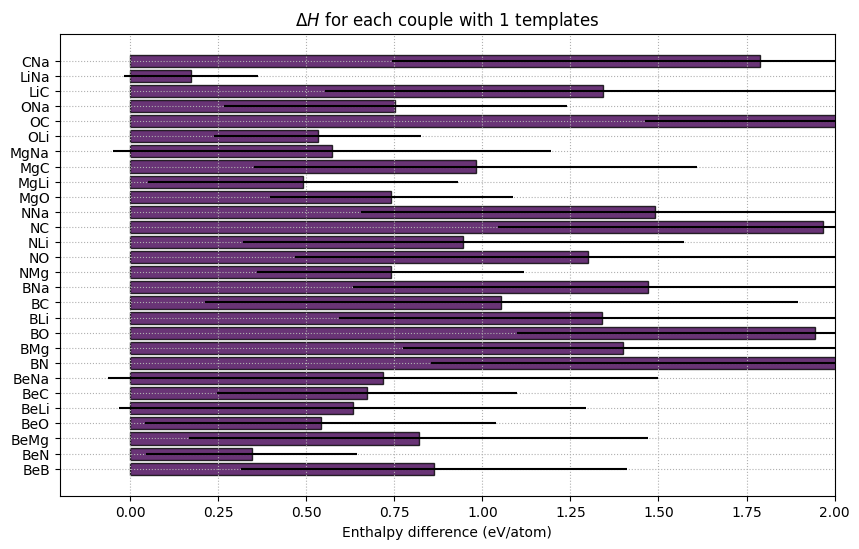

In [39]:
start_time=time.time()
random.seed(time.time())
std_output = sys.stdout
create_directory('./TemplateSets')

#sys.stdout = open(f'./TemplateSets/Log_sets_{hyperparameters["n_sets"]}', 'w')

dif_vec = np.zeros((hyperparameters['n_sets'],28))

ntemp_studied = hyperparameters['ntemp_end'] - hyperparameters['ntemp_start']
dif_mean = np.zeros((ntemp_studied, 28))
dif_std = np.zeros((ntemp_studied,28))
means = np.zeros(ntemp_studied)
stds = np.zeros(ntemp_studied)

for i in tqdm(range(hyperparameters['ntemp_start'],hyperparameters['ntemp_end'])):
    hyperparameters['n_template'] = i
    errors = np.zeros(hyperparameters['n_sets'])
    print('##################################################\n')
    print(f'Generating template set with {i} templates\n')
    print('##################################################\n')

    for k in range(hyperparameters['n_sets']):
        hyperparameters['lev_gen'] = 0.1
        hyperparameters['id_set'] = k

        template_set = generate_one_templateset(hyperparameters, test_elements)
        create_directory(f'./TemplateSets/{template_set.num_template}')
        template_set.print_file(f'./TemplateSets/{template_set.num_template}/TemplateSet_{k}')

        reduction_set = generate_one_pairset(template_set, hyperparameters, test_elements)
        reduction_set.print_relaxed_pairs(f'./TemplateSets/{i}/PairSet_{k}')


        dif_vec[k]= np.array(reduction_set.error_single_composition(hyperparameters))
        errors[k] = reduction_set.total_error(hyperparameters) 
    dif_mean[i-hyperparameters['ntemp_start']] = np.mean(dif_vec, axis=0)
    dif_std[i-hyperparameters['ntemp_start']] = np.std(dif_vec, axis=0)

    graph_difference_std(dif_mean[i-hyperparameters['ntemp_start']] , dif_std[i-hyperparameters['ntemp_start']] , i, (i-hyperparameters['ntemp_start'])/ntemp_studied )
    means[i-hyperparameters['ntemp_start']] = np.mean(errors)
    stds[i-hyperparameters['ntemp_start']] = np.std(errors)

sys.stdout = std_output



In [40]:
with open('IMPORTANT_RESULTS.txt', 'w') as file:
    file.write(f'MEANS: {means}\n')
    file.write(f'STDS: {stds}\n')
    file.write(f'DIFFERENCES: {dif_mean}\n')
    file.write(f'STDS DIFFERENCES: {dif_std}\n')
    

In [41]:
'''
start_time=time.time()
random.seed(time.time())
std_output = sys.stdout
create_directory('./TemplateSets')
sys.stdout = open(os.devnull, 'w')

dif_vec = np.zeros((hyperparameters['n_sets'],28))
ntemp_studied = hyperparameters['ntemp_end'] - hyperparameters['ntemp_start']
dif_mean = np.zeros((ntemp_studied, 28))
dif_std = np.zeros((ntemp_studied,28))
hyperparameters['n_template'] = 21

template_set = generate_one_templateset(hyperparameters, test_elements)
create_directory(f'./TemplateSets/{template_set.num_template}')
template_set.print_file(f'./TemplateSets/{template_set.num_template}/TemplateSet.txt')        
reduction_set = generate_one_pairset(template_set, hyperparameters, test_elements)

sys.stdout = std_output
 '''

"\nstart_time=time.time()\nrandom.seed(time.time())\nstd_output = sys.stdout\ncreate_directory('./TemplateSets')\nsys.stdout = open(os.devnull, 'w')\n\ndif_vec = np.zeros((hyperparameters['n_sets'],28))\nntemp_studied = hyperparameters['ntemp_end'] - hyperparameters['ntemp_start']\ndif_mean = np.zeros((ntemp_studied, 28))\ndif_std = np.zeros((ntemp_studied,28))\nhyperparameters['n_template'] = 21\n\ntemplate_set = generate_one_templateset(hyperparameters, test_elements)\ncreate_directory(f'./TemplateSets/{template_set.num_template}')\ntemplate_set.print_file(f'./TemplateSets/{template_set.num_template}/TemplateSet.txt')        \nreduction_set = generate_one_pairset(template_set, hyperparameters, test_elements)\n\nsys.stdout = std_output\n "

In [42]:
hyperparameters = {
    'ntemp_start' : 8,
    'ntemp_end' : 9,
    'w_f_start' : 0.1,
    'w_f_end' : 10,
    'w_o_start' : 0.1,
    'w_o_end' : 10,
    'w_step' : 0.1,

    'comp' : 1,
    'lev_gen' : 0.0,
    'n_sets' : 2,
    'n_template' : 21,

    'id_set' : 1,
    'lev_red' : 0.7,
    'weight_formation_entalphy' : 1,
    'weight_occurrence' : 1,
    'weight_sg' : 0.001,

    'n_pairs' : 28,
}

test_elements=['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na']

In [43]:
template_set = TemplateSet('./TemplateSets/21/TemplateSet_0')
reduction_set = PairSet(template_set, test_elements, f'./TemplateSets/21/PairSet_0')
graph_reducted_set(reduction_set)

FileNotFoundError: [Errno 2] No such file or directory: './TemplateSets/21/TemplateSet_0'

In [ ]:
import plotly.graph_objects as go
from tqdm import tqdm

nw = round(hyperparameters['w_f_end'] - hyperparameters['w_f_start'],2)
errors = np.zeros((int(nw/hyperparameters['w_step']),int(nw/hyperparameters['w_step'])))
i_values = np.arange(hyperparameters['w_f_start'],hyperparameters['w_f_end'] , hyperparameters['w_step'])
j_values = np.arange(hyperparameters['w_o_start'],hyperparameters['w_o_end'], hyperparameters['w_step'])

std_output = sys.stdout
for i_idx, i in tqdm(enumerate(i_values), total=len(i_values)):
    for j_idx, j in enumerate(j_values):
        hyperparameters['weight_formation_entalphy'] = i
        hyperparameters['weight_occurrence'] = j

        errors[i_idx, j_idx]=reduction_set.total_error(hyperparameters)
sys.stdout = std_output

# Dati di esempio
x = i_values
y = j_values
x, y = np.meshgrid(x, y)
z = errors
# Creazione del grafico 3D
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

# Aggiunta di layout e titolo
fig.update_layout(
    title='Total error as a function of the weights',
    scene = dict(
        xaxis_title='Weight formation enthalpy',
        yaxis_title='Weight occurrence',
        zaxis_title='Total error'),
    width=700,
    height=700
    )

# Mostra il grafico
fig.show()

In [ ]:
n_temp_mean = []
n_temp_std = []

for i in range(1, 22):
    print(f'##################################################\n')
    print(f'Analyzing set with {i} templates\n')
    print(f'##################################################\n')
    
    num_final_temp = np.zeros(10)

    for j in range(0,10):
        template_set = TemplateSet(f'./TemplateSets/{i}/TemplateSet_{j}')
        reduction_set = PairSet(template_set, test_elements, f'./TemplateSets/{i}/PairSet_{j}')
        num_final_temp[j] = len(reduction_set.reduced_set(hyperparameters))

    n_temp_mean.append(np.mean(num_final_temp))
    n_temp_std.append(np.std(num_final_temp))




In [ ]:
coppia = ['Li', 'Na']
sg = 123
wyc = ['1a', '1b'] 
tupla = (coppia,sg, wyc) 
lista = []


['1a', '1b']


In [ ]:
a = [i for i in range(1,20)][0]
a

1